# Aufgabe 3

## 3.1 Fossile Erzeugung

In [5]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

T = 24
timesteps = np.arange(T)

c_CO2 = 7 # EUR/tCO2

# Marginal costs der thermischen Kraftwerke berechnen
thermalPlant = ['Kohle', 'GuD', 'Gasturbine']
power = {'Kohle': 600,
         'GuD': 400,
         'Gasturbine': 300} # MW
efficiency = {'Kohle': 0.41,
         'GuD': 0.58,
         'Gasturbine': 0.4} 
fuel_price = {'Kohle': 10,
         'GuD': 25,
         'Gasturbine': 25} # EUR/MWhprim
emission_factor = {'Kohle': 0.35,
         'GuD': 0.2,
         'Gasturbine': 0.2} # tCO2/MWhprim
MC = {} # marginal costs in EUR/MWh
emissions = {} # emissions in tCO2/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]
    
# Daten laden
df = pd.read_excel('Last_PV_Wind.xlsx')
load = df['Last Sommer [MW]'] # hier nach Gruppennummer Sommer/Winter eingeben
wind = df['Wind 300 MW']
PV_100 = df['PV 100 MW Sommer']
PV_200 = df['PV 200 MW Sommer']

In [9]:
# Pyomo Modell aufstellen

model = pyo.ConcreteModel()

model.x = pyo.Var(thermalPlant, timesteps, within=pyo.NonNegativeReals)

# Zielfunktion
def zielfunktion(model):
    return sum(model.x[n, t] * MC[n] for n in thermalPlant for t in timesteps)
               
model.obj = pyo.Objective(rule=zielfunktion, 
                          sense=pyo.minimize)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = pyo.Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load.loc[t]
model.load_con = pyo.Constraint(timesteps, 
                            rule = load_constraint_rule)

opt = pyo.SolverFactory('gurobi')
opt_success = opt.solve(model)

model.display()

# get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value



Model unknown

  Variables:
    x : Size=72, Index=x_index
        Key                : Lower : Value : Upper : Fixed : Stale : Domain
         ('Gasturbine', 0) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 4) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 5) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 6) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 7) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 8) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 9) :     0 :   0.0 :  None : False : False : NonNegativeReals
     

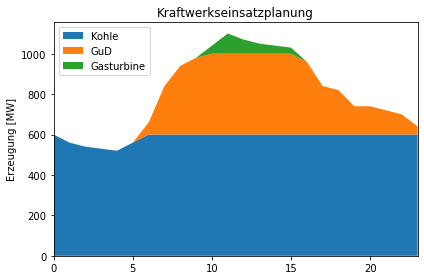

Die Gesamtkosten der Stromversorgung belaufen sich auf: 667814.61 €


In [7]:
# plo
fig, ax = plt.subplots()
ax.stackplot(timesteps, 
             PowerThermal.to_numpy(dtype = float).transpose(), 
             labels=thermalPlant)
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='upper left')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()
plt.show()
print("Die Gesamtkosten der Stromversorgung belaufen sich auf: " + str(round(model.obj(), 2)) + " €")